In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import poligrain as plg
import mergeplg as mplg
import mergeplg.class_structure_of_interpolators as mplg_new

In [3]:
ds_gauges = xr.open_dataset("./data/openmrg_municp_gauge.nc")
ds_cmls = xr.open_dataset("./data/openmrg_cml.nc")
ds_rad = xr.open_dataset("./data/openmrg_rad.nc")
ds_gauges_smhi = xr.open_dataset("./data/openmrg_smhi_gauge.nc")


ref_str = "EPSG:32632"
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

ds_gauges_smhi.coords["x"], ds_gauges_smhi.coords["y"] = (
    plg.spatial.project_point_coordinates(
        ds_gauges_smhi.lon, ds_gauges_smhi.lat, ref_str
    )
)

# Projected radar coords
ds_rad.coords["xs"], ds_rad.coords["ys"] = plg.spatial.project_point_coordinates(
    ds_rad.longitudes, ds_rad.latitudes, ref_str
)

In [4]:
points_to_grid_interpolator = mplg_new.PointsToGridInterpolatorIDW(
    ds_points=ds_gauges_smhi,
    ds_grid=ds_rad,
    max_distance=10e3,
)


In [5]:
interp_result = points_to_grid_interpolator(da_points=ds_gauges.rainfall_amount.sum(dim='time'))

In [6]:
ds_rad.rainfall_amount.isel(time=0)

<xarray.DataArray 'rainfall_amount' (y: 48, x: 37)> Size: 14kB
[1776 values with dtype=float64]
Coordinates:
    time     datetime64[ns] 8B 2015-07-25T12:30:00
  * x        (x) float64 296B -1.542e+05 -1.522e+05 ... -8.42e+04 -8.22e+04
  * y        (y) float64 384B -3.413e+06 -3.415e+06 ... -3.505e+06 -3.507e+06
    xs       (y, x) float64 14kB 6.457e+05 6.478e+05 ... 7.138e+05 7.157e+05
    ys       (y, x) float64 14kB 6.343e+06 6.343e+06 ... 6.441e+06 6.441e+06
Attributes:
    units:    sum 5min

In [7]:
interp_result

<xarray.DataArray (y: 48, x: 37)> Size: 14kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 384B -3.413e+06 -3.415e+06 ... -3.505e+06 -3.507e+06
  * x        (x) float64 296B -1.542e+05 -1.522e+05 ... -8.42e+04 -8.22e+04
    ys       (y, x) float64 14kB 6.343e+06 6.343e+06 ... 6.441e+06 6.441e+06
    xs       (y, x) float64 14kB 6.457e+05 6.478e+05 ... 7.138e+05 7.157e+05

<Axes: xlabel='xs', ylabel='ys'>

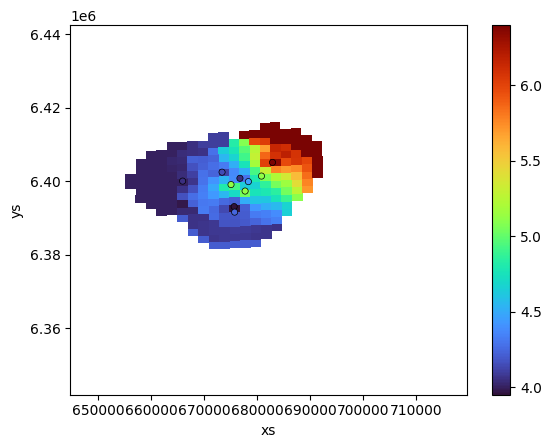

In [8]:
plg.plot_map.plot_plg(
    #da_grid=ds_rad.rainfall_amount.sum(dim='time'),
    da_grid=interp_result,
    da_gauges=ds_gauges.rainfall_amount.sum(dim='time'), use_lon_lat=False)

## Test additive IDW for points

In [9]:
ds_rad = ds_rad.rename({'longitudes': 'lon', 'latitudes': 'lat'})

In [10]:
ds_gauges = ds_gauges.rename({'station_id': 'id'})

In [11]:
merge_additive_idw =  mplg_new.MergeAdditiveIDW(
    ds_grid=ds_rad,
    ds_points=ds_gauges,
    nnear=3,
    p=2,
    max_distance=15e3,
    exclude_nan=True, # not implemented
)

In [12]:
R_with_additive_IDW = merge_additive_idw(
    da_grid=ds_rad.rainfall_amount.sum(dim='time'),
    da_points=ds_gauges.rainfall_amount.sum(dim='time'),
)

<Axes: xlabel='xs', ylabel='ys'>

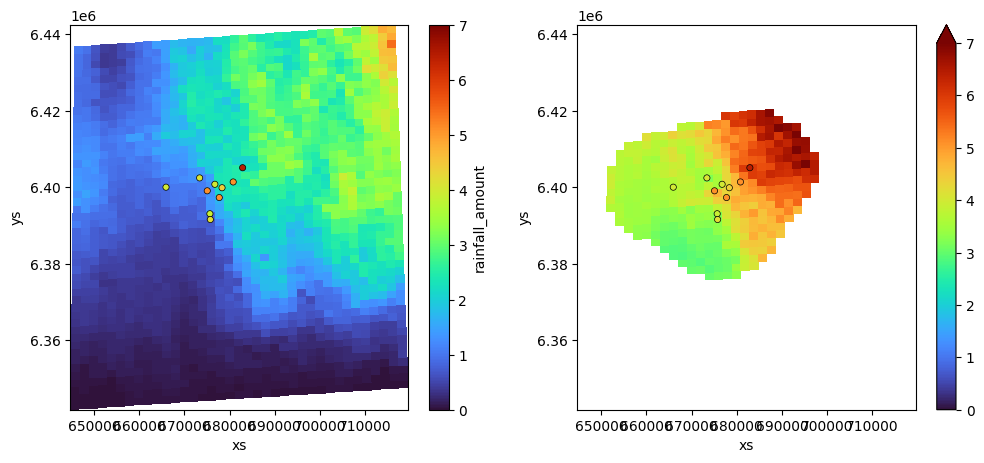

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

vmin = 0
vmax = 7

plg.plot_map.plot_plg(
    da_grid=ds_rad.rainfall_amount.sum(dim='time'),
    da_gauges=ds_gauges.rainfall_amount.sum(dim='time'), 
    use_lon_lat=False,
    ax=axs[0],
    vmin=vmin,
    vmax=vmax,
)

plg.plot_map.plot_plg(
    da_grid=R_with_additive_IDW,
    da_gauges=ds_gauges.rainfall_amount.sum(dim='time'), 
    use_lon_lat=False,
    ax=axs[1],
    vmin=vmin,
    vmax=vmax,
)